In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import rlr_validate, train_neural_net, draw_neural_net, visualize_decision_boundary
import torch

## Load and Prepare Data

In [2]:
# Read file and store as pandas dataframe
filename = '../Data/day.csv'
df = pd.read_csv(filename)
df = df.drop('instant', axis=1)
df = df.drop('dteday', axis=1)
N, M = df.shape
attributeNames = list(df.columns)

### Standardize Data

In [3]:
# Undo the original max-min normalization
temp = df.columns.get_loc("temp")
atemp = df.columns.get_loc("atemp")
hum = df.columns.get_loc("hum")
windspeed = df.columns.get_loc("windspeed")

X = df.values
for row in range(0, N):
    X[row, temp] = X[row, temp]*(39-(-8)) + (-8)
    X[row, atemp] = X[row, atemp]*(50-(-16)) + (-16)
    X[row, hum] = X[row, hum]*100
    X[row, windspeed] = X[row, windspeed]*67
    
# Standarize ratio data attributesPCA
temp_col = df.columns.get_loc("temp")
cnt_col = df.columns.get_loc("cnt")

for col in range(temp_col, cnt_col+1):
    # subtract mean, column by column
    mn = X[:, col].mean(0)
    X[:, col] = X[:, col] - np.ones(N) * mn
    X[:, col] = X[:, col] * (1/np.std(X[:, col]))
    
# Focus on the last 7 attributes
attributeNames = attributeNames[temp_col:cnt_col+1]

### Set 'cnt' as target variable

In [4]:
cnt_col = attributeNames.index("cnt")
# Split dataset into features and target vector
y = X[:,cnt_col]
X = X[:,0:cnt_col]
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset']+attributeNames
M = M+1

## Regularized Linear Regression

In [5]:
# Cross validation
K = 10
CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.,np.linspace(-5,9,100))

## Artificial Neural Network

<Figure size 1000x1000 with 0 Axes>

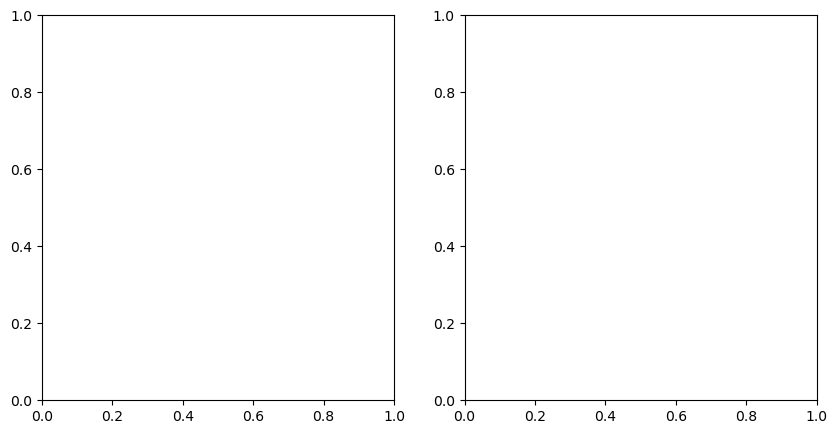

In [6]:
# Setup figure for display of the decision boundary
decision_boundaries = plt.figure(1, figsize=(10,10))
subplot_size_1 = int(np.floor(np.sqrt(K))) 
subplot_size_2 = int(np.ceil(K/subplot_size_1))
plt.suptitle('Data and model decision boundaries', fontsize=20)
plt.subplots_adjust(left=0, bottom=0, right=1, top=.9, wspace=.5, hspace=0.25)
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10,5))
color_list = ['tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
              'tab:gray', 'tab:olive', 'tab:cyan', 'tab:red', 'tab:blue']

In [7]:
# Define the ANN model structure
n_hidden_units = 5
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 10000

model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, n_hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU(),
                    torch.nn.Linear(n_hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
loss_fn = torch.nn.MSELoss()
print('Training model of type:\n\n{}\n'.format(str(model())))

Training model of type:

Sequential(
  (0): Linear(in_features=7, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)



In [8]:
# Initialize variables
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
Error_train_ANN = np.empty((K,1))
Error_test_ANN = np.zeros((K,1))
Errors_ANN = []
opt_h = np.zeros((K,1))                   # optimal ANN hidden units for each outer fold
opt_lambdas = np.empty((K,1))             # optimal lambdas for each outer fold
w_rlr = np.empty((M,K))                   # weights for each attribute with regularisation
w_noreg = np.empty((M,K))                 # weights for each attribute without regularisation
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))

In [ ]:
for k, (train_index, test_index) in enumerate(CV.split(X,y)):
    print('\nCrossvalidation fold: {0}/{1}'.format(k+1,K))    
    internal_cross_validation = 10    
    
    ############################### Lingear Regression ############################### 
    # Extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    opt_val_err,opt_lambdas[k],mean_w_vs_lambda,train_err_vs_lambda,test_err_vs_lambda = \
    rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and std
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambdas[k] * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
    
    # Compute mean squared error without regularization
    Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]
    
    ##################################### ANN ##################################### 
    # Extract test and train tensor sets to train ANN
    X_train = torch.Tensor(X[train_index,:])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index,:])
    y_test = torch.Tensor(y[test_index])
    
    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(model,
                                                       loss_fn,
                                                       X=X_train,
                                                       y=y_train,
                                                       n_replicates=n_replicates,
                                                       max_iter=max_iter)
    print('\n\tBest loss: {}\n'.format(final_loss))
    
    # Determine estimated class labels for test set
    y_test_est = net(X_test)
    # Determine errors
    se = (y_test_est.float()-y_test.float())**2 # squared error
    mse = (sum(se).type(torch.float)/len(y_test)).data.numpy() #mean
    Errors_ANN.append(mse) # store error rate for current CV fold 
    
    # Display the learning curve for the best net in the current fold
    h, = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label('CV fold {0}'.format(k+1))
    summaries_axes[0].set_xlabel('Iterations')
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel('Loss')
    summaries_axes[0].set_title('Learning curves')
    
    # Display the results for the last cross-validation fold
    if k == K-1:
        plt.figure(k, figsize=(12,8))
        plt.subplot(1,2,1)
        plt.semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'-') # Don't plot the bias term
        plt.xlabel('Regularization factor')
        plt.ylabel('Mean Coefficient Values')
        plt.grid()
        
        plt.subplot(1,2,2)
        plt.title('Optimal lambda: 1e{0}'.format(round(np.log10(opt_lambdas[k][0]),5)))
        plt.loglog(lambdas,train_err_vs_lambda.T,'b-',lambdas,test_err_vs_lambda.T,'r-')
        plt.xlabel('Regularization factor')
        plt.ylabel('Squared error (crossvalidation)')
        plt.legend(['Train error','Validation error'])
        plt.grid()
        
        plt.tight_layout()


Crossvalidation fold: 1/10

	Replicate: 1/1
		Iter	Loss			Rel. loss


C:\Users\yufan\anaconda3\envs\course02450\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([657])) that is different to the input size (torch.Size([657, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


		1000	0.46106562	3.328742e-05
		2000	0.45341027	8.150362e-06
		3000	0.45110068	3.2372131e-06
		4000	0.45012292	1.3903933e-06
		Final loss:
		4310	0.44993767	9.935474e-07

	Best loss: 0.4499376714229584


Crossvalidation fold: 2/10

	Replicate: 1/1
		Iter	Loss			Rel. loss


C:\Users\yufan\anaconda3\envs\course02450\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([658])) that is different to the input size (torch.Size([658, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


		1000	0.44484577	1.3063802e-05
		2000	0.44212916	2.8984655e-06
		Final loss:
		2819	0.44147074	9.4509574e-07

	Best loss: 0.441470742225647


Crossvalidation fold: 3/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.48710206	1.982287e-05
		2000	0.48196396	5.3796307e-06
		3000	0.4802908	2.1717656e-06
		Final loss:
		3877	0.47962803	9.941801e-07

	Best loss: 0.4796280264854431


Crossvalidation fold: 4/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.43735048	1.8807083e-05
		2000	0.433091	4.9545165e-06
		3000	0.43163222	2.2094555e-06
		Final loss:
		3913	0.43098673	9.680857e-07

	Best loss: 0.4309867322444916


Crossvalidation fold: 5/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.4606844	6.824478e-05
		2000	0.44561106	1.531521e-05
		3000	0.44138998	5.739104e-06
		4000	0.4396466	2.6436858e-06
		5000	0.43879053	1.4942212e-06
		Final loss:
		5320	0.43861276	9.512539e-07

	Best loss: 0.43861275911331177


Crossvalidation fold: 6/10

	Replicate: 1/1
		Iter	Loss			Rel. loss
		10

In [ ]:
# Display the MSE across folds
summaries_axes[1].bar(np.arange(1, K+1), np.squeeze(np.asarray(Errors_ANN)), color=color_list)
summaries_axes[1].set_xlabel('Fold')
summaries_axes[1].set_xticks(np.arange(1, K+1))
summaries_axes[1].set_ylabel('MSE')
summaries_axes[1].set_title('Test mean-squared-error')

plt.show()

### Display Linear Regression Results

In [ ]:
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

In [ ]:
# Show weight values in text form
# for fold in range(K):
#     print('Weights in fold {}/{}:'.format(fold+1, K))
#     for m in range(M):
#         print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,fold],5)))        
#     print('\n')

In [ ]:
# Bar plot of RLR weights
weights = [1,2,3,4,5,6]      # skip offset
bw = .15
r = np.arange(1,K+1)

for i in weights:    
    plt.bar(r+i*bw, w_rlr[i,:], width=bw)
    
plt.xticks(r+bw, range(1,K+1))
plt.xlabel('Attributes')
plt.ylabel('Weights')
plt.legend(attributeNames[1:M+1], loc=(1.04, 0))
plt.grid()
plt.title('Weights from each fold of Regularized Linear Regression')
plt.show()

### Display ANN Results

In [ ]:
print('Diagram of best neural net in last fold:')
weights = [net[i].weight.data.numpy().T for i in [0,2]]
biases = [net[i].bias.data.numpy() for i in [0,2]]
tf =  [str(net[i]) for i in [1,2]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print('\nEstimated generalization error, RMSE: {0}'.format(round(np.sqrt(np.mean(errors)), 4)))

# When dealing with regression outputs, a simple way of looking at the quality
# of predictions visually is by plotting the estimated value as a function of 
# the true/known value - these values should all be along a straight line "y=x", 
# and if the points are above the line, the model overestimates, whereas if the
# points are below the y=x line, then the model underestimates the value
plt.figure(figsize=(10,10))
y_est = y_test_est.data.numpy(); y_true = y_test.data.numpy()
axis_range = [np.min([y_est, y_true])-1,np.max([y_est, y_true])+1]
plt.plot(axis_range,axis_range,'k--')
plt.plot(y_true, y_est,'ob',alpha=.25)
plt.legend(['Perfect estimation','Model estimations'])
plt.title('cnt: estimated versus true value (for last CV-fold)')
plt.ylim(axis_range); plt.xlim(axis_range)
plt.xlabel('True value')
plt.ylabel('Estimated value')
plt.grid()

plt.show()


### Table 1

In [ ]:
print("Outer fold \tANN \t\t\tLinear Regression \t\tBaseline")
print("i \t\th∗_i \tEtest_i \tlambda_i \tEtest_i \tEtest_i")
for i in range(K):
    print("{} \t\t{:.3f} \t{:.3f} \t\t{:.2e} \t{:.3f} \t\t{:.3f}".format(\
        i+1,opt_h[i][0],Error_test_ANN[i][0],opt_lambdas[i][0],Error_test_rlr[i][0],Error_test_nofeatures[i][0]))